# When will the UK Population be Fully Vaccinated Against Covid-19?



Basics of Covid-19 vaccines:
- when first vaccine given
- 2 doses (space between)
- AstraZeneca and Pfizer
- priority groups


## Setup

In [1]:
# Get data from the internet
import requests
import json

# Analyse data and dates
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualisations
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use("seaborn-notebook")
fontsize = 14
plt.rc('font', size=fontsize)
plt.rc('axes', titlesize=fontsize)
plt.rc('axes', labelsize=fontsize)
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize)
width = 12
height = 5
figsize = (width, height)
%matplotlib inline

## Getting the data

The government has developed a Coronavirus dashboard which is updated daily with key statistics including the number of Covid-19 tests, cases, hospitalisations, deaths and vaccinations. You can view the dashboard here: https://coronavirus.data.gov.uk/

All of the source data can be downloaded, for example as a spreadsheet, by clicking the "download" button under each table or graph. Even better for our purposes is that the dashboard has an "Application Programming Interface" (API), which we can use to extract precisely the data we're interested in programmatically from this notebook!

The documentation for the API is found under the ["Developer's Guide" section](https://coronavirus.data.gov.uk/details/developers-guide) of the dashboard, which describes the various parameters that are available and how they should be configured. In particular, there are Python examples which show us how to structure a data query. There are three main steps, as follows:

**Step 1:** Defining the geographical region we are interested in. Some of the data is available regionally as well as nationally. The number of positive cases, for example, is available both for the UK as a whole but also down to "local authority" level (local council areas, of which there are over 300 in England alone). However, the vaccination data we're interested in is only available as summary totals for the whole UK (although this is perfect for our purposes).

In the API, to define that we wish to retrieve summary data for the whole UK we must set the `areaType` parameter to be the value "overview", as follows:

In [2]:
filters = "areaType=overview"

**Step 2:** Defining which statistics (data columns) we wish to retrieve. To explore the status of the vaccination programme we would like to know the number of new first and second vaccine doses administered on each day, and the overall (cumulative) total of first and second doses administered up to and including each day.

In the API these fields are given long names like `newPeopleVaccinatedFirstDoseByPublishDate`. Finding the correct names for the data you're interested can be a bit tricky. Most are listed in the documentation but not all - the vaccination data has been added fairly recently and isn't documented, for example. Usually the field names for the API match the column names in files downloaded from the web-site, so you can do some super sleuthing and find them that way if you'd like to try an analysis with different data!

As the names are long the API helpfully let's us rename them to something more convenient in the dictionary format seen below. We'll call the cumulative totals `cumFirst` and `cumSecond`, and the new doses each day `newFirst` and `newSecond`. Finally, to pass this dictionary to the API it must be converted into a string without any spaces, which we achieve using the `json.dumps` function.

In [3]:
# define which data columns we wish to retrieve, and what to call them
structure = {
    "date": "date",
    "newFirst": "newPeopleVaccinatedFirstDoseByPublishDate",
    "cumFirst": "cumPeopleVaccinatedFirstDoseByPublishDate",
    "newSecond": "newPeopleVaccinatedSecondDoseByPublishDate",
    "cumSecond": "cumPeopleVaccinatedSecondDoseByPublishDate",
}

# convert the dictionary into a string without spaces (using the separators argument)
structure = json.dumps(structure, separators=(",", ":"))

**Step 3:** Submitting the API query. We can now package our parameters up into the structure required by the API, and  send our query using the `requests.get` function. If the query is successful we should seee a status code of 200 ([as per the convention for request status codes](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status#successful_responses)). If not it should also come back with a useful error message to diagnose the problem with our query.

In [4]:
# query the API for the data
ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"

api_params = {
    "filters": filters,
    "structure": structure
}
response = requests.get(ENDPOINT, params=api_params, timeout=10)

if response.status_code != 200:
    raise RuntimeError(f'Request failed: { response.text }')

Our query was successful but where is the data? We can convert the data the request contains into a Python function using the `.json()` method on the response, and then look at what fields are contained in the data (the keys of the dictionary):

In [5]:
j = response.json()
print(j.keys())

dict_keys(['length', 'maxPageLimit', 'totalRecords', 'data', 'requestPayload', 'pagination'])


This doesn't look like the vaccination data we're expecting yet. The response also includes metadata about our query, in particular whether we queried too much data to return in one go. If the "length" of our query was larger than the  "maxPageLimit" we'd have to split our query into multiple queries.

In [6]:
print(j["length"], j["maxPageLimit"])

113 2500


In this case we are a long way under the limit so we should have all the data. To find it we can have a look at one of the elements in the "data" list:

In [7]:
print(j["data"][0])

{'date': '2021-05-02', 'newFirst': 83220, 'cumFirst': 34588600, 'newSecond': 171332, 'cumSecond': 15500949}


Each element of the "data" list contains the vaccination data for one day. To make it easier to analyse the data we can convert it to a pandas data frame, using the date as the unique index for the rows (as we have one row for each day). We also take care to properly convert the date string representations into actual Python datetimes, so we can benefit from pandas' features for processing time series data. We also convert the numbers into units of 1 million to make them easier to read in figures and tables later.

In [8]:
df = pd.DataFrame(j["data"])

# use the "date" column to index our data
df.set_index("date", inplace=True)
# convert the date text strings into Python datetimes
df.index = pd.to_datetime(df.index)
# sort the data from oldest to newest
df.sort_index(inplace=True)

# convert all totals to millions
df = df / 1e6

df.tail()

,newFirst,cumFirst,newSecond,cumSecond
date,,,,
2021-04-28,0.134140,34.094048,0.462885,14.043961
2021-04-29,0.122568,34.216616,0.491567,14.535528
2021-04-30,0.145589,34.362205,0.421785,14.957313
2021-05-01,0.143175,34.505380,0.372304,15.329617
2021-05-02,0.083220,34.588600,0.171332,15.500949


Later on, it will also be helpful to have data on the total number of doses given, i.e.  the number of first doses plus the number of second doses. Pandas let's us quickly create new columns for these values, as follows:

In [9]:
df["newTot"] = df["newFirst"] + df["newSecond"]
df["cumTot"] = df["cumFirst"] + df["cumSecond"]

Our query above gets all the data up to the current date. To ensure re-running the notebook reproduces the same results from the time of writing only data up to the XXX of April should be included, which is done using the `run_as_date` variable below. If you'd like to see the latest results instead you can change the value to today's date.

In [10]:
# To reproduce the results at the time of publishing the story set the date below to
# 13th April 2021 (run_as_date = datetime(2021, 4, 13)), or use today's date to update
# the results with the latest available data (run_as_date = datetime.now()).
run_as_date = datetime.now()

# filter the data to only include dates up to the run_as_date
df = df[df.index < run_as_date]


## Vaccines so far

Now we have the data we need to start forecasting the future of the vaccination programme, but before we jump in it's always a good idea to explore the historical data first. Let's take a look at the first row of our data:

In [11]:
df.iloc[0]

newFirst          NaN
cumFirst     2.286572
newSecond         NaN
cumSecond    0.391399
newTot            NaN
cumTot       2.677971
Name: 2021-01-10 00:00:00, dtype: float64

Although the first Covid-19 vaccine in the UK (outside of clinical trials) was administered on 8th December 2020, the daily data that we have starts on 10h January 2021, by which time 2.29 million first doses and 0.39 million second doses had been given. Since that date a mean (average) of 0.34 million (340,000) first doses and 0.07 million (70,000)  second doses have been administered per day:

In [12]:
df["newFirst"].mean(), df["newSecond"].mean()

(0.2884109642857143, 0.13490669642857142)

As of XXX a total of 31.90 million people have been vaccinated with a first dose and 6.54 million with a second dose, which we can see by looking at the last row of the data:

In [13]:
df.iloc[-1]

newFirst      0.083220
cumFirst     34.588600
newSecond     0.171332
cumSecond    15.500949
newTot        0.254552
cumTot       50.089549
Name: 2021-05-02 00:00:00, dtype: float64

To make sense of these numbers we are missing one more piece of data - how many people are there to vaccinate? We can't get that information from the API, but we can take it from the [government's vaccine delivery plan](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/951928/uk-covid-19-vaccines-delivery-plan-final.pdf). The plan specifies that the UK adult population (children are not currently being vaccinated) is approximately 53 million people, as well giving the sub-totals for the nine priority groups who will receive vaccines first. Government targets typically focus on three goals - vaccinating the 15 million people in priority groups 1-4 (the over 70s, care home residents, and health & social care workers), the 32 million people in the groups 1-9 (additionally including over 50s and the clinically vulnerable), and the whole adult population. Comparing to the numbers above, we can see that first doses for groups 1-9 have recently been completed as well as over half of the seecond doses for groups 1-4.

We'll be using the priority group totals regularly so let's save them for further use:

In [14]:
# no. people to vaccinate in each priority group (in millions)
priority_totals = {
    "Groups 1-4": 15,
    "Groups 1-9": 32,
    "All Adults": 53
}

It's helpful to visualise the data, so before continuing we will do a bit of work here to set up plotting functions we can re-use throughout our analysis. First let's define colours and labels to use for the data columns in all the figures we create. These are in the `col_format` dictionary below, which all our plotting functions can access.

Then we define a function `plot_column`, which uses the pandas `plot` function to plot a column from the dataset in our chosen style. It also includes options to display a weekly rolling average of the data, rather than the original raw data, calculated using the statement `df[column].rolling(window=7).mean()` below (where `window=7` means we calculate the average across 7 days). Finally, it will be helpful to distinguish between actual historical vaccine data, and estimates from the forecasts we create. If the `forecast_date` argument is defined the data after that date will be plotted with a dashed line instead of a solid line. The data after that date is selected using the statement `data[data.index >= forecast_date]`.

In [15]:
col_format = {
    "cumFirst": {"label": "1st", "color": "orange"},
    "cumSecond": {"label": "2nd", "color": "deepskyblue"},
    "cumTot": {"label": "Total", "color": "k"},
    "newFirst": {"label": "1st", "color": "orange"},
    "newSecond": {"label": "2nd", "color": "deepskyblue"},
    "newTot": {"label": "Total", "color": "k"},
}


def plot_column(
    df, column, ax, forecast_date=None, rolling=False, **kwargs
):
    """
    Plot a column in a data frame, optionally calculating its rolling weekly
    average and distinguishing between actual and forecasted data.
    df - vaccination data frame
    column - column of df to plot
    ax - matplotlib axis to use for the plot
    forecast_date - plot data from this date with a dashed line
    rolling - plot rolling weekly average instead of raw data
    **kwargs - additional arguments passed to pandas plotting function
    """
    color = col_format[column]["color"]
    label = col_format[column]["label"]
        
    if rolling:
        data = df[column].rolling(window=7).mean()
        label = label + " (7d avg)"
    else:
        data = df[column]
        
    if forecast_date is None:
        data.plot(color=color, label=label, ax=ax, **kwargs)
    else:
        # plot actual data with solid line
        data[data.index <= forecast_date].plot(
            color=color, label=label, ax=ax, linestyle="-", linewidth=3, **kwargs
        )
        # plot forecast data with dashed line
        data[data.index >= forecast_date].plot(
            color=color, label="Forecast " + label, ax=ax, linestyle="--", **kwargs
        )


As well as showing the number of doses, we'd like to make it clear when each population sub-group has been vaccinated. To determine the date a group was fully vaccinated (with 1st or 2nd doses) we can find the first date where the total number of doses exceeds that group's population, using the statement `df[df[column] >= (pop - tol)].index[0]`. The `tol` parameter here is a small value used to account for any rounding errors in the forecasts we do later. The `annotate_group_completions` function below can then be used to add horizontal and vertical lines and text labels to a plot for those completion dates.

We should note that there will be a slight margin of error in the actual completion dates. There is regional variation in the speed of the rollout, one area may start vaccinating group 5 before another area has finished vaccinating group 4, for example, and groups are being vaccinated in parallel. It's therefore not strictly correct to state all people in groups 1-4 have been vaccinated as soon as 15 million vaccines have been administered nationally. The population in each priority group is also estimated as the groups can be overlapping. For example, a clinically vulnerable, 50 year-old social care worker meets the criteria for priority groups 2, 6 and 9. 

In [16]:
def annotate_group_completions(
    df, column, ax, text_offset=1.02, tol=1e-7
):
    """
    Add text labels and lines indicating the date population
    sub-groups were vaccinated.
    df - vaccination data frame
    column - column to add labels for, either cumFirst or cumSecond
    ax - matplotlib axix to add labels to
    text_offset - space between data point and text label
    tol - define group to be vaccinated if total vaccines is within tol of its population
    """
    label = col_format[column]["label"]
    max_col = df[column].max()

    for name, pop in priority_totals.items():
        if max_col >= (pop - tol):  # vaccines completed for this group
            complete_date = df[df[column] >= (pop - tol)].index[0]

            ax.hlines(pop, 0, complete_date, color="k", linewidth=0.5)
            ax.vlines(complete_date, 0, pop, color="k", linewidth=0.5)
            ax.text(
                complete_date,
                pop*text_offset,
                f"{name}\n{label} Doses\n{complete_date.date()}",
                ha="center",
                size=12,
                fontweight="bold",
            )


Now we are almost there! The `plot_cumulative_doses` function below uses the two previous functions to display the history of the total number of people vaccinated with first and second doses:

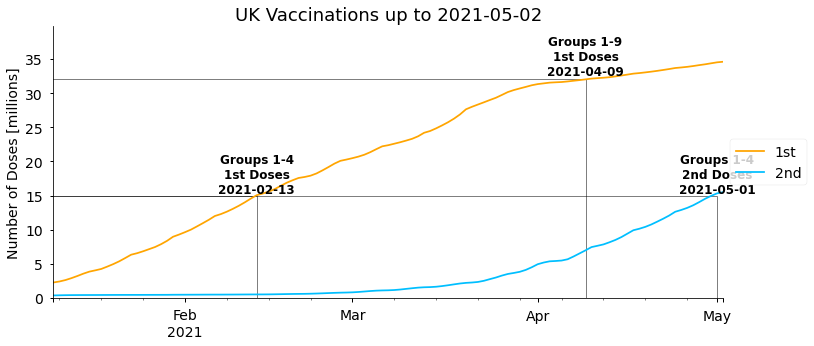

In [17]:
def plot_cumulative_doses(
    df, forecast_date=None, figsize=figsize, title=None
):
    """
    Plot cumulative first and second doses, and the dates when
    the vaccination of prioriy groups completed.
    Optionally distinguish actual data and forecasted data. Data
    after forecast_date will be displayed with a dashed line.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)  # remove border lines
    ax.spines["top"].set_visible(False)

    for col in ["cumFirst", "cumSecond"]:
        plot_column(
            df, col, ax,
            forecast_date=forecast_date,
        )
        annotate_group_completions(df, col, ax)

    ax.set_ylim(0, df["cumFirst"].max() * 1.15)
    ax.set_ylabel("Number of Doses [millions]")
    ax.set_xlabel("")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if title is not None:
        ax.set_title(title, fontsize=18)

        
plot_cumulative_doses(
    df, title=f"UK Vaccinations up to {df.index.date.max()}"
)

As stated in [Boris Johnson's address to the nation on 4th January 2021](https://www.gov.uk/government/speeches/prime-ministers-address-to-the-nation-4-january-2021), the first target the government set was to offer the first dose of a vaccine to everyone in the top four priority groups by mid-February. As we can see above this target was met on 13th February. The [next target set by the government](https://www.gov.uk/government/speeches/prime-ministers-statement-on-coronavirus-covid-19-10-february-2021) was then to offer a first dose to the first nine priority groups (the over 50s) with a first dose by the end of April. This was somewhat pessimistic given the vaccination rates at the time, and was ultimately completed a couple of weeks earlier on 9th April. Overall, the start of the UK vaccination programme has been very successful and amongst the fastest in the world.

It's also interesting to look at the daily number of new doses each day, and this is particularly relevant for forecasting future doses. We can create a similar function to do this, but as there's quite a large variation in the day to day totals (more on this below) we'll show the actual values as markers only and include lines for the weekly rolling averrages instead. We'll also display the combined total of 1st and 2nd doses (`newTot`) administered on each day, as this gives the best representation of the overall vaccine supply and capacity to administer vaccines.

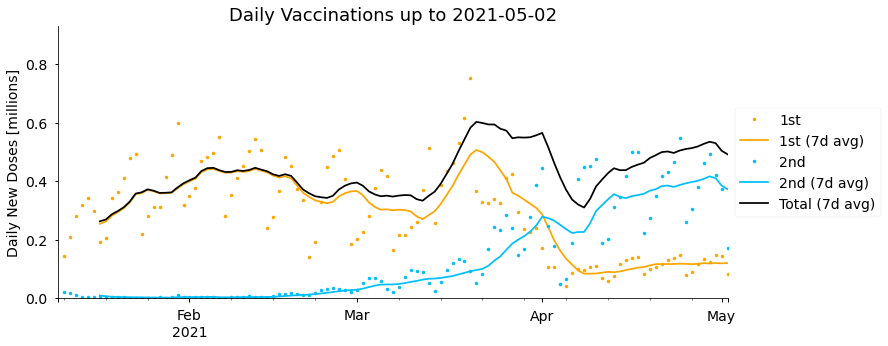

In [18]:
def plot_daily_doses(
    df, forecast_date=None,
    show_daily=True, show_rolling=True,
    figsize=figsize, title=None
):
    """
    Plot daily first doses, second doses, the sum of 1st
    and 2nd doses, and their weekly rolling averages.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    for col in ["newFirst", "newSecond", "newTot"]:
        if show_daily and col != "newTot":   # display daily data           
            plot_column(df, col, ax, marker=".", linestyle="None")

        if show_rolling:  # display 7 day averages
            plot_column(
                df, col, ax,
                forecast_date=forecast_date,
                rolling=True
            )

    ax.set_ylim(0, df["newTot"].max() * 1.1)
    ax.set_xlabel("")
    ax.set_ylabel("Daily New Doses [millions]")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if title is not None:
        ax.set_title(title, fontsize=18)

        
plot_daily_doses(
    df, title=f"Daily Vaccinations up to {df.index.date.max()}"
)

Between January and until early February the vaccine doses administered per day steadily increased from around 0.25 million to 0.45 million on average. After that date rates plateaued and temporarily fell, mostly due to challenges and [fluctuations in securing vaccine supplies](https://news.sky.com/story/covid-19-daily-drop-off-in-vaccinations-is-down-to-supply-fluctuations-but-will-pick-up-says-prof-jonathan-van-tam-12227465). Late March saw the highest rates, peaking at 0.6 million doses per day in the week starting 14th March, though this has since fallen again, particularly over the Easter weekend (2nd-5th April). Supply difficulties are currently [expected to continue in coming months](https://www.theguardian.com/politics/2021/apr/06/england-covid-vaccine-programme-could-slow-sharply-sage-warns). As well as fluctuations in the total we can see that the number of second doses administered has been steadily increasing, and overtook the rate of new first doses in early April. More on this later.

If you look closely at the actual daily numbers of 1st and 2nd doses (the markers rather than the rolling average lines), it seems like they vary up and down with a period of 7 days. We can make this clearer by plotting the number of doses delivered on each weekday. The day of the week for all the dates in our data can be determined using the pandas function `day_name`. Then we make use of the `boxplot` function in the `seaborn` plotting library to show the distribution in doses delivered on each weekday:

Text(0, 0.5, 'Daily Doses (1st + 2nd) [millions]')

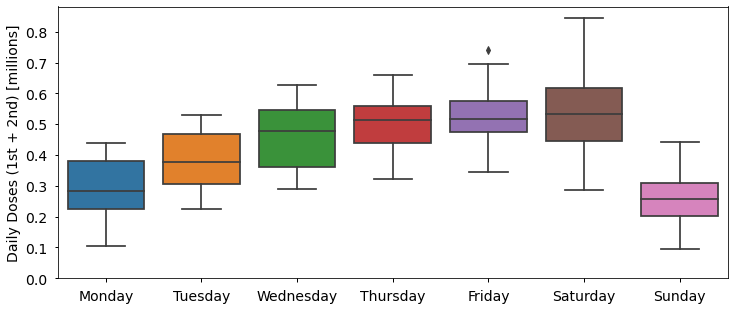

In [19]:
df["weekday"] = df.index.day_name()

plt.figure(figsize=figsize)
sns.boxplot(
    x="weekday", y="newTot", data=df,
    order=[
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday",
        "Sunday"
    ]
)
plt.xlabel("")
plt.ylim([0, plt.ylim()[1]])
plt.ylabel("Daily Doses (1st + 2nd) [millions]")

In [20]:
df.groupby("weekday")["newTot"].mean()

weekday
Friday       0.524323
Monday       0.296048
Saturday     0.530277
Sunday       0.262091
Thursday     0.502456
Tuesday      0.382108
Wednesday    0.465922
Name: newTot, dtype: float64

More doses are administered Wednesday to Saturday than Sunday to Tuesday, with on average half as many (0.25 million) delivered on Sunday than on Friday (0.50 million). Although I could not find an official explanation for this, one factor is likely related to the capacity and opening hours of vaccination centres and GP surgeries, which are more likely to be closed on Sundays for example. Other statistics have similar trends, such as [fewer Covid-19 deaths being recorded at weekends due to reporting delays](https://www.bbc.co.uk/news/health-52167016).

## When are Second Doses Being Given?

A high-profile decision announced by the UK Joint Committee on Vaccination and Immunisation (JCVI) [on the 30th December 2020](https://www.gov.uk/government/publications/priority-groups-for-coronavirus-covid-19-vaccination-advice-from-the-jcvi-30-december-2020/joint-committee-on-vaccination-and-immunisation-advice-on-priority-groups-for-covid-19-vaccination-30-december-2020), was to delay second doses by as long as possible up to 12 weeks instead of the originally recommended 3-4 weeks. The decision was taken to be able to protect as many people as possible with a single dose of the vaccine within the first few months of the year, but [was fairly controversial at the time](https://www.bmj.com/content/372/bmj.n18) due to clinical trials using shorter gaps between doses.

The delay between first and second doses will be an important component in our forecasts, so let's calculate when second doses are actually being given in practice (more precisely than "up to 12 weeks"). We can estimate this by determining the number of days until the total number of second doses (`cumSecond`) matches the total number of first doses (`cumFirst`) on a given date. The for loop below calculates the delay for all dates in the past, and then prints the most recent delay:

In [21]:
for date_2nd, row in df.sort_index(ascending=False).iterrows():
    if row["cumSecond"] >= df["cumFirst"].min():
        # find the last date where number of 1st doses is less than
        #  or equal to number of 2nd doses on current row
        date_1st = df[df["cumFirst"] <= row["cumSecond"]].index.max()
        # calculate how many days it was until 2nd doses were given
        delay = (date_2nd - date_1st).days
        df.loc[date_2nd, "delaySecond"] = delay
    else:
        break

avg_second_delay = df["delaySecond"][-1]
print(
    "1st doses from",
    (df.index[-1] - timedelta(days=avg_second_delay)).date(),
    "were completed", avg_second_delay,
    "days later, on", df.index[-1].date()
)


1st doses from 2021-02-14 were completed 77.0 days later, on 2021-05-02


Currently, second doses are lagging first doses by 74 days, or around ten and a half weeks. In the history of the data so far, the delay has varied between 71 and 75 days:

In [22]:
df["delaySecond"].min(), df["delaySecond"].max()

(71.0, 77.0)

With the gap increasing from 72 to 75 days over the Easter weekend (2nd-5th April) where fewer doses (of any type) were administered than normal:

Text(0, 0.5, '2nd Dose Delay [days]')

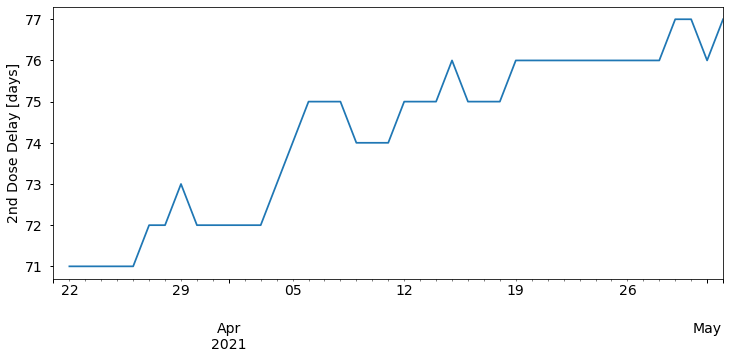

In [23]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
df.loc[
    df.index >= datetime(2021, 3, 21),
    "delaySecond"
].plot(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("2nd Dose Delay [days]")

The second dose delay values we calculate here are averages for the whole country. In reality, the actual gap between doses for each individal will vary depending on the availability of appointments and vaccination strategy in their area. 

## Forecasting Future Vaccinations

Now we have a good idea about what's happened so far, but knowing that how can we forecast when the UK might fully vaccinate the adult population? At a high level, there will be two components to our forecasts: estimates for the total number of doses that will be administered on each future date, and of how those doses will be divided between first doses and second doses. We won't specify the exact form of our total daily doses estimation for now, except saying that it will be a function depending on two arguments - the date we want an estimate for, and the previous vaccination data. This general form will allow us to quickly try a few different forecasting approaches later.

For the second part (deciding which of the available vaccines will be given as first or second doses) we will make a number of assumptions that apply to all the forecasts we generate, as follows:
- Everyone is given two doses of a vaccine.
- Second doses are given `avg_second_delay` days after first doses (as calculated above). This means we expect the cumulative total of second doses today to match the cumulative total of first doses `avg_second_delay` days ago. Or equivalently, the number of new second doses required today is the difference between the current cumulative total of second doses and the cumulative total of first doses `avg_second_delay` days ago.
- Second doses are given priority over new first doses. New first doses will only be given if the total number of doses available on a given day is more than the number of people requiring a second dose.
- Once there is capacity to do so, second doses can be given sooner than `avg_second_delay` days later. [Current UK guidance](https://www.gov.uk/government/publications/priority-groups-for-coronavirus-covid-19-vaccination-advice-from-the-jcvi-30-december-2020/joint-committee-on-vaccination-and-immunisation-advice-on-priority-groups-for-covid-19-vaccination-30-december-2020) is that second doses of the Pfizer vaccine can be administered after 3 weeks, or after 4 weeks for the AstraZeneca vaccine, and up to 12 weeks later for both.
- 100% of the UK adult population will be vaccinated.

These assumptions generally seem reasonable, but there are limitations with all of them. It's likely that [booster doses of Covid-19 vaccines will be needed](https://www.bmj.com/content/372/bmj.n664), so ultimately people may receive more than two doses (so we're predicting only the completion of the first phase of the UK vaccination programme). Alternatively, single-dose vaccines such as the [Johnson & Johnson vaccine](https://www.bbc.co.uk/news/world-us-canada-56226979) may start to be administered. New vaccine types coming online may also invalidate our third assumption above, as doses of a new vaccine can only be given as first doses initially - they can't be prioritised for second doses straight away like other vaccines (unless people begin to be given two doses of different vaccine types). Although it seems reasonable to give second doses earlier once there is spare capacity to do so, we don't know whether this will be the case and it may be that spare capacity is re-directed elsewhere. Finally, vaccine [uptake in the over 50s has been close to 95%](https://www.gov.uk/government/speeches/statement-on-vaccination-progress-and-new-variants), but not 100% and it's possible uptake will decrease in younger age groups. We should keep all these limitations in mind when interpreting the results.

The `forecast_vaccines` function below encodes everything described above. We give the vaccination data so far (as the input `df`), add new rows for future dates up to a specified `end_date`, determine how many doses will be administered on each date using a function `doses_fn` (that we haven't defined yet), and distributes those doses according to our assumptions. In many places the `timedelta` function from the python `datetime` library is used to get data from a number of days before the forecast date.


In [24]:
def forecast_vaccines(
    df,
    avg_second_delay,
    doses_fn,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1),
    min_second_delay=28,
):
    """
    Forecast future vaccine doses.

    df: DataFrame of actual vaccine data.
    avg_second_delay: Days after 1st dose that 2nd doses will be given.
    doses_fn: Function to calculate number of doses administered each
    day. Takes 2 arguments - df and a date.
    uk_pop: Total population to be vaccinated.
    end_date: Forecast until this date.
    min_second_delay: If there is spare capacity, allow second doses to
    be given earlier than avg_second_delay, down to this number of days.
    """
    # extend our time series index to the future
    first_data = df.index.min()
    last_data = df.index.max()
    if end_date < last_data:
        raise ValueError(
            f"end_date ({end_date}) should be after the last date in df {last_data}"
        )
    future_dates = pd.date_range(last_data, end_date, closed="right")
    df = df.append(pd.DataFrame(index=future_dates))
    df.sort_index(inplace=True)

    for d in future_dates:
        if d - timedelta(days=avg_second_delay) < first_data:
            # no 1st dose data avg_second_delay ago, assume no 2nd doses required
            pending_2nd_doses = 0
        else:
            # 2nd doses needed is difference between 2nd doses so far and 1st
            # doses avg_second_delay days ago (who now require 2nd dose)
            dose2_req = df.loc[
                d - timedelta(days=avg_second_delay), "cumFirst"
            ]
            dose2_sofar =  df.loc[
                d - timedelta(days=1), "cumSecond"
            ]
            pending_2nd_doses = max([0, dose2_req - dose2_sofar])

        # use forecasting function to determine number of doses available today
        total_doses_today = doses_fn(df, d)

        # don't vaccinate more than the total population (with 2 doses)
        if total_doses_today + df.loc[d - timedelta(days=1), "cumTot"] > 2 * uk_pop:
            total_doses_today = 2 * uk_pop - df.loc[d - timedelta(days=1), "cumTot"]

        # give all 2nd doses required (up to limit of total doses available)
        dose2_today = min(pending_2nd_doses, total_doses_today)

        # remaining vaccines given as new 1st doses
        dose1_remaining = uk_pop - df.loc[d - timedelta(days=1), "cumFirst"]
        dose1_today = min(total_doses_today - dose2_today, dose1_remaining)
        
        # if there are spare doses, try giving 2nd doses earlier than usual
        if dose1_today + dose2_today < total_doses_today:
            dose2_poss_early = df.loc[
                d - timedelta(days=min_second_delay), "cumFirst"
            ] 
            dose2_today = min(total_doses_today - dose1_today, dose2_poss_early)
        
        # save today's values
        df.loc[d, "newSecond"] = dose2_today
        df.loc[d, "cumSecond"] = df.loc[d - timedelta(days=1), "cumSecond"] + dose2_today
        df.loc[d, "newFirst"] = dose1_today
        df.loc[d, "cumFirst"] = df.loc[d - timedelta(days=1), "cumFirst"] + dose1_today
        df.loc[d, "newTot"] = dose1_today + dose2_today
        df.loc[d, "cumTot"] = df.loc[d, "cumFirst"] + df.loc[d, "cumSecond"]
        
    return df


The final piece of estimating the number of doses that will be available in the future is also where we have the least certainty. The scale and speed of the Covid-19 vaccine rollout worldwide is unprecedented and there have been challenges, such as with [lower production than expected in supply chains](https://www.ft.com/content/df5020f4-461e-443e-8d55-f3234690d049), and other delays such as the [rollout of the AstraZeneca vaccine being paused in some countries](https://www.sciencemag.org/news/2021/03/european-countries-resume-use-astrazenecas-covid-19-vaccine-hoping-pause-has-not-dented) to investigate side-effects.

Given these circumstances it's possible future vaccine supply in the UK could be quite different to past supply. But as a starting point let's consider a simpler question - when will the UK population be vaccinated if doses continue to be given at the same rate as the last week? In the last week, vaccines have been given at a rate of:

In [25]:
mean_doses_this_week = df["newTot"].tail(7).mean()
print(
    "Between", df.index[-7].date(), "and", df.index[-1].date(),
    f"there was a mean of {mean_doses_this_week:.2f}",
    "million doses given per day."
)

Between 2021-04-26 and 2021-05-02 there was a mean of 0.49 million doses given per day.


Now all we need to run our forecast is to create the function to calculate how many doses are available each day. In this case it can be a simple function (`const_doses` below) that always returns the 0.40 million average daily doses calculated above. Even though we don't use them here, the function must have two inputs (`df` and `date`) to be compatible with our general `forecast_vaccines` function created above. Let's wrap all this into a function `forecast_const` we can easily use to run forecasts with other constant daily dose totals, then run it on our last week average:

In [26]:
def forecast_const(
    df,
    avg_second_delay,
    daily_doses,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1),
    min_second_delay=28,
):
    """
    Forecast vaccines assumming 'daily_doses' doses are given per day.
    """
    def const_doses(df, date):
        return daily_doses
    
    df_forecast = forecast_vaccines(
        df,
        avg_second_delay,
        doses_fn=const_doses,
        uk_pop=uk_pop, 
        end_date=end_date,
        min_second_delay=min_second_delay,

    )

    return df_forecast


df_forecast = forecast_const(df, avg_second_delay, mean_doses_this_week)

We can re-use our plotting functions to examine our forecast. Let's start with the daily number of 1st and 2nd doses given per day:

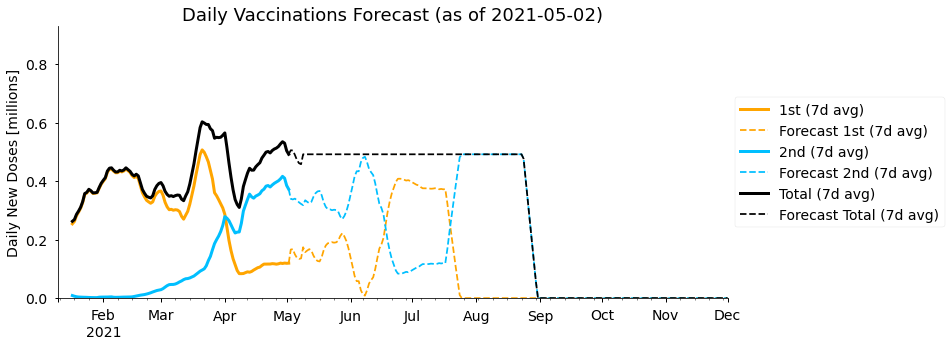

In [27]:
last_data = df.index.max()

plot_daily_doses(
    df_forecast, forecast_date=last_data,
    show_daily=False,
    title=f"Daily Vaccinations Forecast (as of {df.index.date.max()})"
)

As expected, the total number of (1st + 2nd) doses given per day remains constant throughout our simple forecast. In the 1st and 2nd doses we see an interesting pattern where every couple of months the doses being administered swap between being mostly first doses or mostly second doses. In fact, the period over which this happens is approximately the 74 day gap between first and second doses we have assumed. At the start of the year (almost) the whole vaccine capacity was dedicated to giving new first doses, and then starting from late March all those people must be given second doses, meaning there is little spare capacity for new first doses. Our forecast predicts we will need to go through this cycle two times to vaccinate the whole population with two doses.

Now let's look at when we predict each sub-group of the population will be vaccinated:

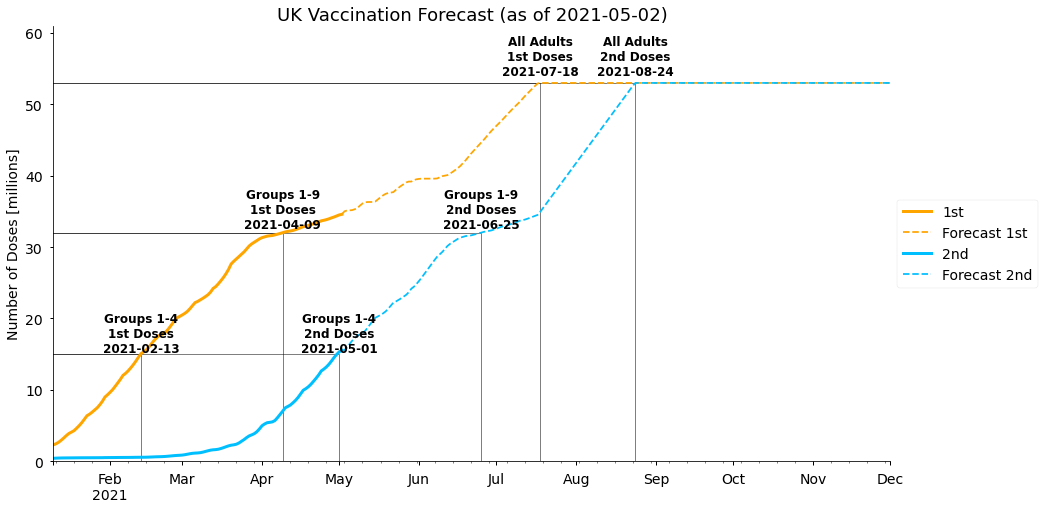

In [28]:
plot_cumulative_doses(
    df_forecast, forecast_date=last_data, figsize=(15, 8),
    title=f"UK Vaccination Forecast (as of {df.index.date.max()})"
)

The current phase of mostly second dose vaccines being given leads to groups 1-4 being fully vaccinated by the end of April, and groups 1-9 being fully vaccinated by late June in our forecast. The rest of the adult population is given a first dose of the vaccine by 27th July, and then is fully vaccinated on 8th September. Note that this gap is only 43 days (less than the 74 days between doses we use initially), as we allow second doses to be given earlier once there is spare capacity to do so. 

## Alternative Forecasts

Our forecast assumed doses will continue to be given at the rate from the the last week, but looking back at the data we can see that this is higher than at most other times so far this year. Although it's possible the number of daily doses increases further in the future, we could consider that to be fairly optimistic. What if we ask a more pessimsitic question - when will the population be vaccinated with two doses if vaccines are administered at the same rate as the whole year so far? Or, even better, what is the range of likely completion dates?

To answer this, we'll create a new `doses_fn` (`rnd_doses` below) where the total number of doses given on any date in the future is the same as the number given on a day in the past, with that day selected randomly. We also limit the date in the past to have the same weekday as the forecast date, to take into account the differences during the week seen earlier (with more doses given Thursday-Saturday). Because the number of doses is chosen randomly, each time the forecast is run we'll get a different result. By running the forecast many times we can get an estimate of the uncertainty in the completion dates. This is done using `forecast_rnd` function below, which returns a list of 200 forecasts:

In [193]:
def forecast_rnd(
    df,
    avg_second_delay,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1),
    min_second_delay=28,
    rng=np.random.default_rng(seed=123),
    n_forecasts=100,
):
    """
    Run n_forecasts random forecasts, using the random number
    generator rng to randomly choose the number of doses today
    to be the same as a date in the past on the same weekday.
    """
    def rnd_doses(df, date):
        doses = rng.choice(
            df.loc[
                df.index.dayofweek == date.dayofweek, "newTot"
            ].dropna()
        )
        return doses

    forecasts = [
        forecast_vaccines(
            df,
            avg_second_delay,
            doses_fn=rnd_doses,
            uk_pop=uk_pop, 
            end_date=end_date,
            min_second_delay=min_second_delay,
        )
        for _ in range(n_forecasts)
    ]

    return forecasts


n_forecasts = 200
rnd_forecasts = forecast_rnd(df, avg_second_delay, n_forecasts=n_forecasts)

If we plot the number of daily doses in each of the 200 forecasts we get a spread of values centred around the average rate for the year, as expected:

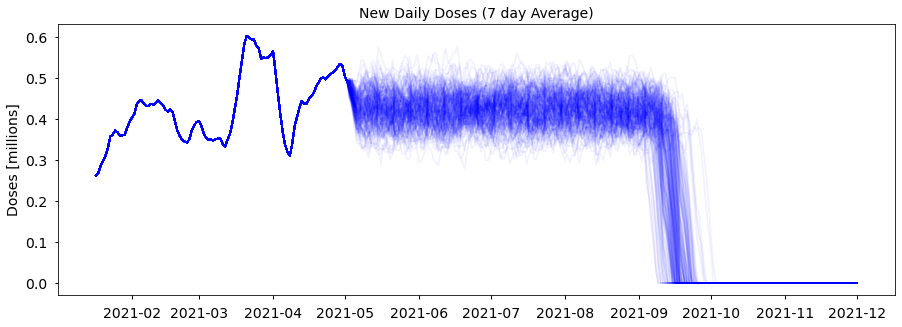

In [194]:
plt.figure(figsize=(15, 5))
for fcast in rnd_forecasts:
    plt.plot(
        fcast["newTot"].rolling(window=7).mean(),
        alpha=10 / n_forecasts,
        color="b"
    )
    
plt.ylabel("Doses [millions]")
plt.title("New Daily Doses (7 day Average)");

Rather than plotting each of the 200 individual forecasts, let's calculate 50% (median), 2.5% and 97.5% quantiles of the forecasts, specifically of the cumulative total of first and second doses. 95% of the forecast values lie between the 2.5% and 97.5% quantiles, so we can be confident the future data will be in that range (but only under our assuumption that vaccines are given at the same rate as the year so far). To do that we can combine all the data for one column into a single data frame with the `pd.concat` function, then calculate the quantiles with the pandas `quantiles` function:

In [195]:
quantiles = [0.025, 0.5, 0.975]
q_forecasts = {}

for col in ["cumFirst", "cumSecond"]:
    rnd_col = pd.concat(
        [
            fcast[col].rename(f"forecast{i}")
            for fcast in rnd_forecasts
        ],
        axis=1, names=[0, 1]
    )
    q_forecasts[col] = rnd_col.quantile(quantiles, axis=1)


Now let's plot the median of our forecasts, create a shaded range between the 2.5% and 97.5% quantiles to show the uncertainty (with the matplotlib function `fill_between`), and also display our original "last week" forecast to compare:

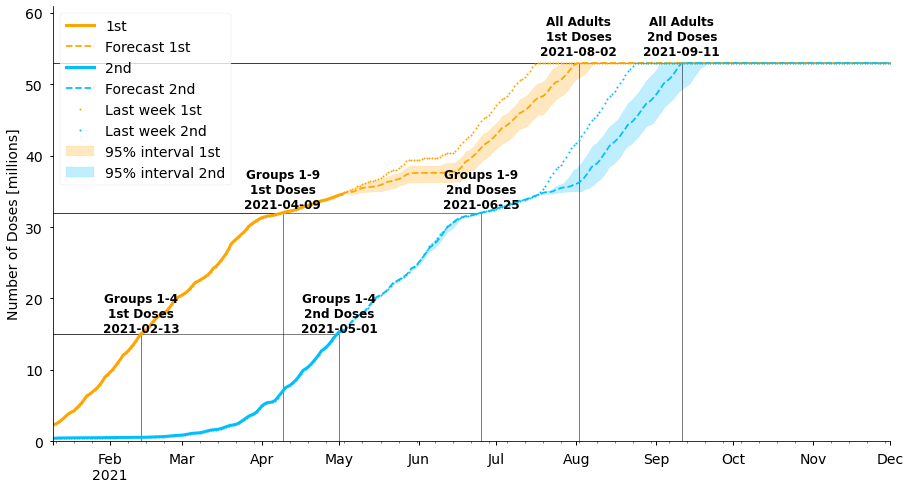

In [196]:
plot_cumulative_doses(
    pd.DataFrame(
        {
            "cumFirst": q_forecasts["cumFirst"].loc[0.5],
            "cumSecond": q_forecasts["cumSecond"].loc[0.5]
        }
    ),
    forecast_date=last_data, figsize=(15, 8), 
)

q_start = 0.025
q_end = 0.975
alpha = 0.25
for col in ["cumFirst", "cumSecond"]:
    # add shaded region between q_start and q_end quantiles
    plt.fill_between(
        q_forecasts[col].loc[q_start].index,
        q_forecasts[col].loc[q_start],
        q_forecasts[col].loc[q_end],
        color=col_format[col]["color"],
        alpha=alpha,
        label=f"95% interval {col_format[col]['label']}"
    )
    # also show previous (last week average) forecast, to compare
    df_forecast[col].plot(
        linestyle="None",
        marker=".",
        markersize=4,
        color=col_format[col]["color"],
        label=f"Last week {col_format[col]['label']}"
    )

plt.legend()

Under these assumptions, the population is fully vaccinated with two doses a few weeks later in mid-September rather than late-August. Note that our original forecast using the last 7 days only lies outside of the uncertainty band for out new forecast. In other words, the population will only be vaccinated by the end of August if vaccines continue to be given at their current high rate without reverting back to lower rates seen earlier in the year.

If we implemented a more sophisticated forecasting algorithm, such as an [autoregressive](https://en.wikipedia.org/wiki/Autoregressive_model) or [Bayesian structural time series](https://minimizeregret.com/post/2020/06/07/rediscovering-bayesian-structural-time-series/) model, we may be able to get improved estimates that incorporate the likelihood of both our "optimistic" and "pessimistic" cases.

## Government Targets and SAGE Vaccine Rollout Estimates

The government has the target of all UK adults being [offered a first dose of the vaccine by the end of July](https://www.bbc.co.uk/news/uk-56141867). This is roughly in line with both of our forecasting approaches, with our optimistic forecast being a bit earlier in mid-July and the pessimistic forecast early-August. At the end of March, the Scientific Advisory Group for Emergencies (SAGE) also [produced a report](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/975909/S1182_SPI-M-O_Summary_of_modelling_of_easing_roadmap_step_2_restrictions.pdf) including the following two scenarios for the vaccine rollout in England:
- **Fast scenario:** 0.39m doses per day in England until week commencing 26th July and 0.29m per day thereafter
- **Slow scenario:** 0.36m doses per day in England until week commencing 26th July and 0.29m per day thereafter

Approximately scaling these up for the whole UK (56 million population England, 67 million population UK) gives:
- **Fast scenario:** 0.46m doses per day until week commencing 26th July and 0.34m per day thereafter
- **Slow scenario:** 0.43m doses per day until week commencing 26th July and 0.34m per day thereafter

The SAGE forecasts use an 11-week (77 day) period between doses, which is also in line with what we derived ourselves from the data.

We can implement the assumptions from SAGE ourselves in our own forecasts just by creating a new `doses_fn` (`sage_doses` below) that returns a fixed number of doses depending on whether we're using the fast or slow strategy, and whether the date is after the 26th July or not:

In [197]:
def forecast_sage(
    df,
    avg_second_delay=77,
    scenario="fast",
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1),
    min_second_delay=77,

):
    """
    Forecast vaccines for the SAGE 'fast' and 'slow' scenarios.
    """
    if not (scenario == "fast" or scenario == "slow"):
        raise ValueError("scenario must be 'fast' or 'slow'")
    
    def sage_doses(df, date, scenario=scenario):
        if date > datetime(2021, 7, 25):
            return 0.34
        else:
            if scenario == "fast":
                return 0.46
            else:
                return 0.43

    df_forecast = forecast_vaccines(
        df,
        avg_second_delay,
        doses_fn=sage_doses,
        uk_pop=uk_pop, 
        end_date=end_date,
        min_second_delay=min_second_delay,
    )

    return df_forecast


Then we can generate and plot the forecasts in the same way as we've done before (displaying both the fast and slow strategies in the same figure):

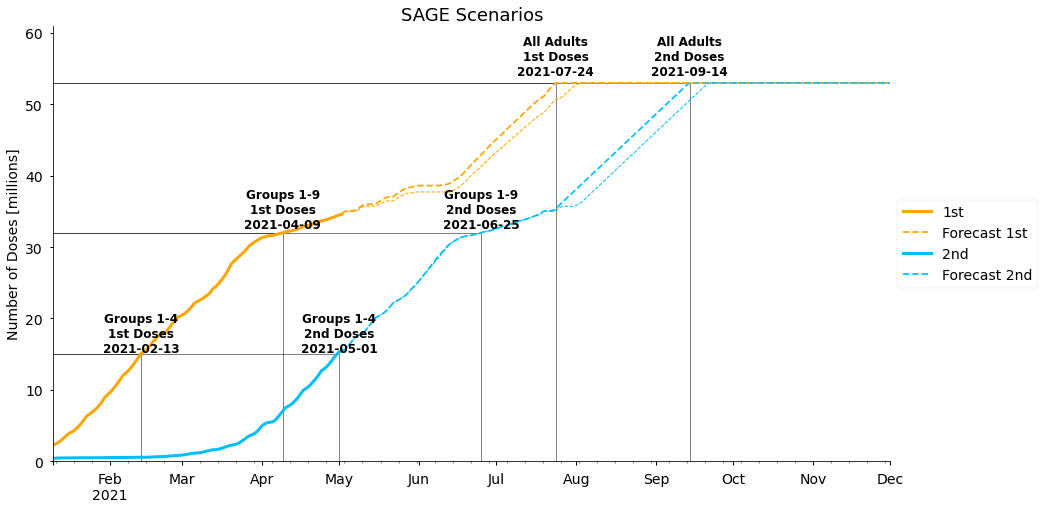

In [198]:
df_sage_fast = forecast_sage(
    df,
    scenario="fast",
)
df_sage_slow = forecast_sage(
    df,
    scenario="slow",
)

plot_cumulative_doses(
    df_sage_fast, forecast_date=last_data, figsize=(15, 8),
    title=f"SAGE Scenarios"
)

plt.plot(
    df_sage_slow["cumFirst"],
    color="orange", linestyle="--", linewidth=1
)
plt.plot(
    df_sage_slow["cumSecond"],
    color="deepskyblue", linestyle="--", linewidth=1
)


The SAGE forecasts are similar to our more pessimistic forecasts, with the population fully vaccinated in mid-September, though the difference between their "slow" and "fast" strategies is smaller than the uncertainty we calculated.

## Conclusion

In this Turing Data Story, we have used data collected from the UK government's Covid-19 data dashboard (using their API) to estimate when the UK may finish fully vaccinating its population. The forecasts were made using simple assumptions and approximations about how vaccine doses will be distributed, including that second doses are given 77 days after first doses (which we derived from the data). 

With the demands and challenges of worldwide vaccine supply it's difficult to accurately estimate how many vaccine doses will be available in the future, so we generated two sets of forecasts - a more optimistic forecast assuming that vaccines will continue to be given at an average of XXX doses per day, which was the rate in the week up to the XXX of May, and a more pessimistic forecast assumiing vaccines are given at a rate consistent with that of the whole year so far. In our optimistic forecast the population is fully vaccinated on 24th August, or in our pessimistic forecasts a few weeks later in mid-September. Our pessimistic forecast is broadly in agreement with the assumptions in modelling by SAGE and with government targets.

Vaccinating the full population with two doses will not be the end of the UK vaccination programme, with [booster shots likely to be rolled out in the autumn](https://www.bmj.com/content/373/bmj.n1116) (starting shortly after we estimate the the first phase of the vaccination programme to be finished). But we can be hopeful that life in the UK will be much less impacted by Covid-19 on a daily basis by that time (though it's difficult to say whether it will return back to what was considered to be "normal" before 2020!) It also won't mark the end of the worldwide pandemic, with the Covid-19 case rates in many countries sadly still being high and vaccination rates low at the time of writing.

This [excellent dashboard from Our World in Data](https://ourworldindata.org/covid-vaccinations#source-information-country-by-country) shows vaccination progress worldwide, including links to data sources that (with some pre-processing) could also be fed into the forecasting functions developed here. For European countries, the European Centre for Disease Prevention and Control has [a combined dataset available](https://www.ecdc.europa.eu/en/publications-data/data-covid-19-vaccination-eu-eea). Do feel free to experiment with this notebook, either using data from other countries or by using different forecasting algorithms, for example. Thanks for reading!


# BACKUP


## weekly quantiles

In [36]:
weekly_avg = df["newTot"].resample("W", label="left").mean()
# label="left" uses week start dates to label our averages, rather
# than week end dates (which is the default)

Text(0, 0.5, 'Week Starting')

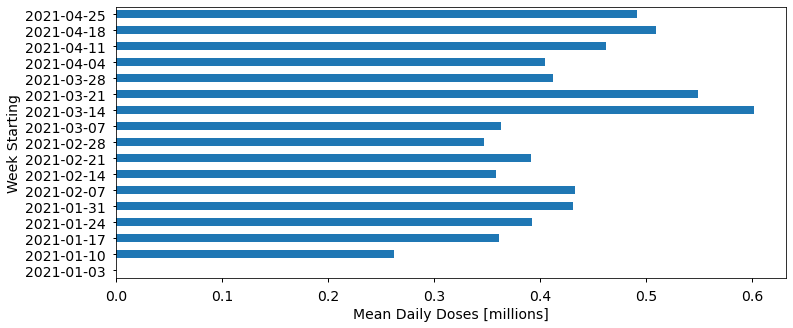

In [37]:
# only keep the date (not time) to tidy up axis labels
weekly_avg.index = weekly_avg.index.date

plt.figure(figsize=figsize)
weekly_avg.plot.barh()
plt.xlabel("Mean Daily Doses [millions]")
plt.ylabel("Week Starting")

In [38]:
quantiles = [0.1, 0.25, 0.75, 0.9]
weekly_avg.quantile(q=quantiles)

0.10    0.352644
0.25    0.362859
0.75    0.469738
0.90    0.529387
Name: newTot, dtype: float64

The quantile values above show that 25% of the weeks to date had daily averages of 0.36 million doses administered per day or lower, and 25% had more than 0.43 million doses per day (or equivalently 75% had 0.43 million or lower).

In [39]:
forecast_q = {}
daily_doses_q = {}

for q in quantiles:
    daily_doses_q[q] = weekly_avg.quantile(q=q)
    forecast_q[q] = forecast_const(
        df,
        avg_second_delay,
        daily_doses_q[q],
        uk_pop=priority_totals["All Adults"], 
    )


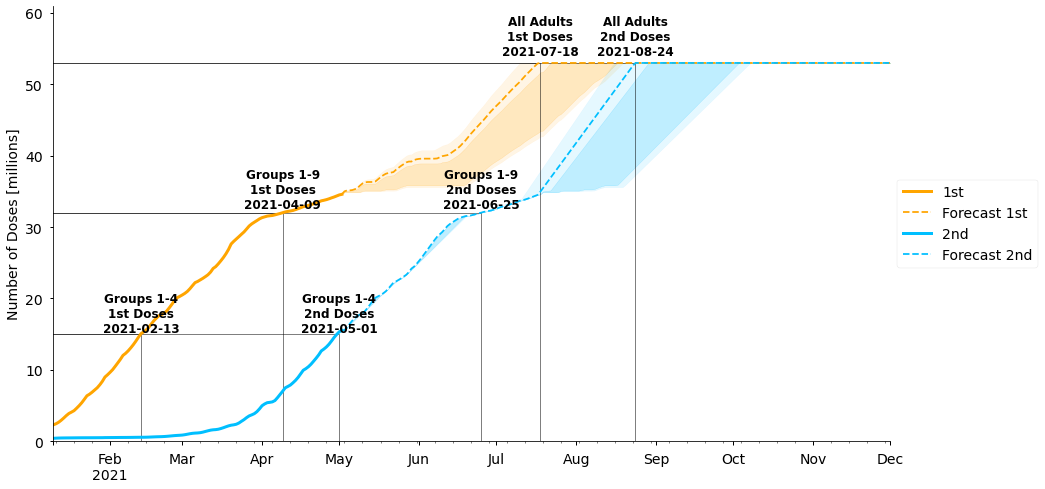

In [40]:
plot_cumulative_doses(
    df_forecast, forecast_date=last_data, figsize=(15, 8), 
)

q_fill = [
    # start quantile, end quantile, fill opacity (alpha)
    (0.1, 0.25, 0.1),
    (0.25, 0.75, 0.25),
    (0.75, 0.9, 0.1)
]

for q_start, q_end, alpha in q_fill:
    for column in ["cumFirst", "cumSecond"]:
        plt.fill_between(
            forecast_q[q_start].index,
            forecast_q[q_start][column],
            forecast_q[q_end][column],
            color=col_format[column]["color"],
            alpha=alpha,
        )


## Forecast with doses today = same as doses N days ago

If the previous week repeated, when will each group be vaccinated?

In [41]:
def forecast_lookback(
    df,
    avg_second_delay,
    days_lookback=7,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 12, 1),
):
    """
    Forecast vaccine data assuming the number of vaccines given
    today is the same as 'days_lookback' days ago.
    """
    def lookback(df, date, days=days_lookback):
        """
        Return total number of doses given a number of days before
        the input date.
        """
        if date - timedelta(days=days) < df.index.min():
            return df.iloc[0]["newTot"]
        else:
            return df.loc[date - timedelta(days=days), "newTot"]

    df_forecast = forecast_vaccines(
        df,
        avg_second_delay,
        doses_fn=lookback,
        uk_pop=uk_pop, 
        end_date=end_date,
    )

    return df_forecast


In [42]:
df_forecast = forecast_lookback(df, avg_second_delay)

Text(0, 0.5, 'Total Doses [millions]')

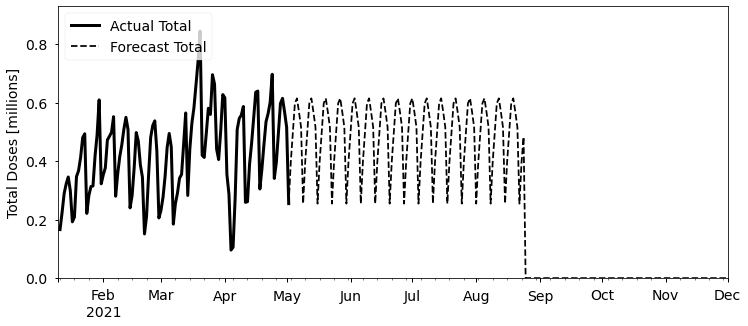

In [43]:
plt.figure(figsize=figsize)

total = df_forecast["newTot"]
last_data = df.index.max()
total[total.index <= last_data].plot(color="k", label="Actual Total", linewidth=3)
total[total.index >= last_data].plot(color="k", linestyle="--", label="Forecast Total")

plt.legend(loc="upper left")
plt.ylim([0, 1.1 * total.max()])
plt.ylabel("Total Doses [millions]")

## Forecast - Random sample doses

(0.040604222982378035, -3.1862864363077534, 3.6066302170706344)


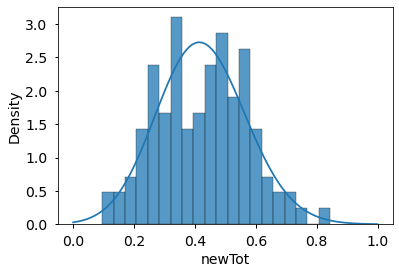

In [44]:
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

data = df["newTot"].dropna()

s = lognorm.fit(data)
print(s)
plt.figure()
sns.histplot(data, stat="density", bins=20)
x = np.linspace(0, 1, 100)
y = lognorm.pdf(x, *s)
plt.plot(x, y)
plt.show()



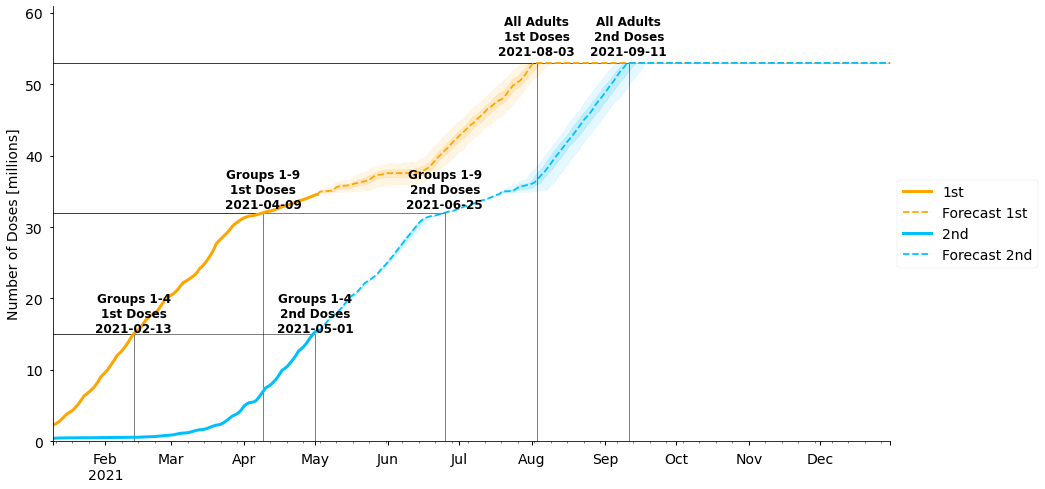

In [45]:
n_forecasts = 100
rng = np.random.default_rng(seed=123)

def rnd_doses(df, date):
    return lognorm.rvs(*s, random_state=rng)


rnd_forecasts = [
    forecast_vaccines(
        df,
        avg_second_delay,
        doses_fn=rnd_doses,
        uk_pop=priority_totals["All Adults"], 
        end_date=datetime(2021, 12, 31),
        min_second_delay=28,
    )
    for _ in range(n_forecasts)
]

rnd_cumFirst = pd.concat(
    [rnd_forecasts[i]["cumFirst"].rename(f"forecast{i}") for i in range(n_forecasts)],
    axis=1, names=[0, 1]
)
rnd_cumSecond = pd.concat(
    [rnd_forecasts[i]["cumSecond"].rename(f"forecast{i}") for i in range(n_forecasts)],
    axis=1, names=[0, 1]
)

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

q_1st = rnd_cumFirst.quantile(quantiles, axis=1)
q_2nd = rnd_cumSecond.quantile(quantiles, axis=1)

plot_cumulative_doses(
    pd.DataFrame({"cumFirst": q_1st.loc[0.5], "cumSecond": q_2nd.loc[0.5]}),
    forecast_date=last_data, figsize=(15, 8), 
)

q_fill = [
    # start quantile, end quantile, fill opacity (alpha)
    (0.025, 0.25, 0.1),
    (0.25, 0.75, 0.25),
    (0.75, 0.975, 0.1)
]

for q_start, q_end, alpha in q_fill:
    plt.fill_between(
        q_1st.loc[q_start].index,
        q_1st.loc[q_start],
        q_1st.loc[q_end],
        color=col_format["cumFirst"]["color"],
        alpha=alpha,
    )
    plt.fill_between(
        q_2nd.loc[q_start].index,
        q_2nd.loc[q_start],
        q_2nd.loc[q_end],
        color=col_format["cumSecond"]["color"],
        alpha=alpha,
    )

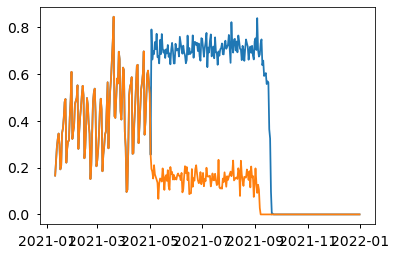

In [46]:
rnd_newTot = pd.concat(
    [rnd_forecasts[i]["newTot"].rename(f"forecast{i}") for i in range(n_forecasts)],
    axis=1, names=[0, 1]
)

q_tot = rnd_newTot.quantile(quantiles, axis=1)

plt.plot(q_tot.loc[0.975])
plt.plot(q_tot.loc[0.025])

28 2021-09-03 00:00:00
10 2021-09-22 00:00:00


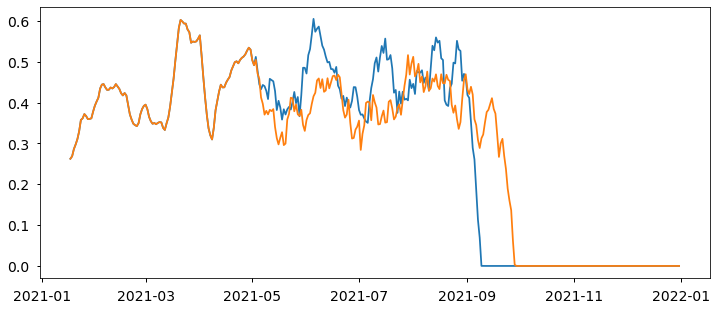

In [47]:
dates = [
    d[d["cumSecond"] >= priority_totals["All Adults"] - 1e-9].index.min()
    for d in rnd_forecasts
]
print(np.argmin(dates), min(dates))
print(np.argmax(dates), max(dates))

plt.figure(figsize=figsize)
plt.plot(rnd_forecasts[np.argmin(dates)]["newTot"].rolling(window=7).mean())
plt.plot(rnd_forecasts[np.argmax(dates)]["newTot"].rolling(window=7).mean())

In [48]:
rnd_forecasts[np.argmax(dates)].loc[rnd_forecasts[np.argmax(dates)]["newTot"] > 0, "newTot"].mean()
#0.37 -> 0.44

0.4051844274509805

## Stability of Forecasts


In [49]:
def run_forecasts(
    df,
    run_start,
    days_lookback=7,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2022, 3, 1)
):
    """
    Calculate the completion date of the UK vaccination programme
    with different forecast start dates. A forecast is run as if
    it was every day starting from the date run_start, up to the
    date of the latest available data.
    """
    forecast_start_dates = pd.date_range(    
        start=run_start, end=df.index.max()
    )
    # fill missing second dose delay values with nearest available value
    df["delaySecond"] = df["delaySecond"].bfill()

    completion_dates = pd.Series(index=forecast_start_dates, dtype=float)
    for forecast_start in forecast_start_dates:
        second_delay = df.loc[forecast_start - timedelta(days=1), "delaySecond"]
        df_forecast = forecast_lookback(
            df[df.index <= forecast_start],
            second_delay,
            days_lookback=days_lookback,
            uk_pop=uk_pop, 
            end_date=end_date
        )
        if df_forecast["cumSecond"].max() >= (uk_pop - 1e-7):
            finish_date = df_forecast[df_forecast["cumSecond"] >= (uk_pop - 1e-7)].iloc[0].name
            completion_dates.loc[forecast_start] = finish_date
        else:
            print(forecast_start.date(), ": Population not vaccinated by ", end_date.date())
            completion_dates.loc[forecast_start] = end_date
    
    return completion_dates

In [50]:
completion_dates = run_forecasts(df, datetime(2021, 2, 1))

Text(0.5, 0, 'Forecast Date')

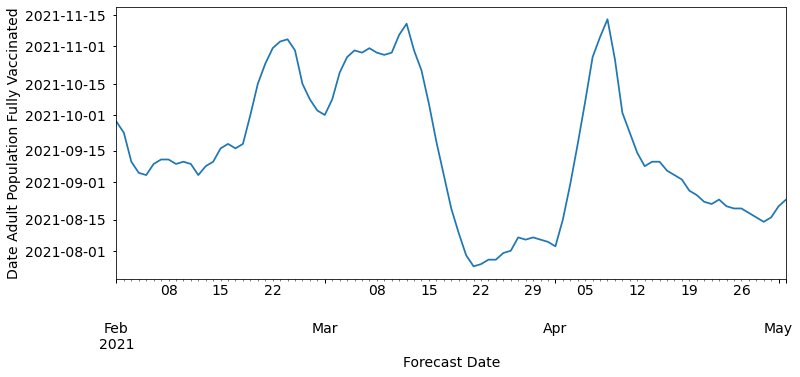

In [51]:
plt.figure(figsize=figsize)
completion_dates.plot()
plt.ylabel("Date Adult Population Fully Vaccinated")
plt.xlabel("Forecast Date")

Effect of Easter Bank Holiday

Stabilised mid-September?

There are several forecasts between late February and early March where the vaccine programme is not completed until January 2022, 2-3 months later than most forecasts at that time that have end dates in October. This looks a bit strange (why such big jumps?), but if we plot one of the forecasts with a late completion date we can see what's happening:

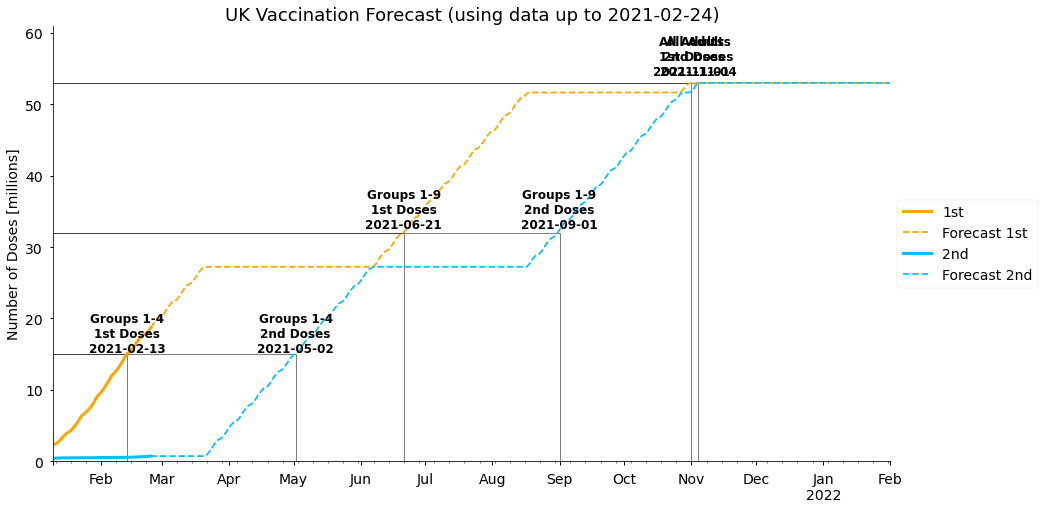

In [52]:
df_feb24 = forecast_lookback(
    df[df.index <= datetime(2021, 2, 24)],
    df.loc[datetime(2021, 2, 24), "delaySecond"],
    end_date=datetime(2022, 2, 1),
)
plot_cumulative_doses(
    df_feb24,
    forecast_date=datetime(2021, 2, 24),
    figsize=(15, 8), 
    title=f"UK Vaccination Forecast (using data up to {datetime(2021, 2, 24).date()})"
)

In the plot above, we see that in this forecast almost all adults are fully vaccinated by 20th August. However, before the remaining first doses can be given, a new batch of people requiring their second dose appear and must be given priority (without spare capacity for new first doses). 73 days later, on 1st November, the last few adults can start to be given their first dose. You'll notice that this 73 day delay in giving the last first doses is closely linked to the 72 day gap we assumed earlier between giving first doses and second doses. We can think of vaccines being given in alternating 72 day cycles of 1st doses and 2nd doses (at least in our simple forecast), and in the example above we have had to go through one additional cycle to complete the vaccination programme (compared to most forecasts which have completion datea in autumn 2021).

BUT
- assuming whole pop gets vaccinated etc.
- delay 2nd doses few days more in this case?

## prophet

In [53]:
from prophet import Prophet

In [54]:
df

,newFirst,cumFirst,newSecond,cumSecond,newTot,cumTot,weekday,delaySecond
date,,,,,,,,
2021-01-10,NaN,2.286572,NaN,0.391399,NaN,2.677971,Sunday,71.0
2021-01-11,0.145076,2.431648,0.020768,0.412167,0.165844,2.843815,Monday,71.0
2021-01-12,0.207661,2.639309,0.016065,0.428232,0.223726,3.067541,Tuesday,71.0
2021-01-13,0.278943,2.918252,0.009745,0.437977,0.288688,3.356229,Wednesday,71.0
2021-01-14,0.316694,3.234946,0.005257,0.443234,0.321951,3.678180,Thursday,71.0
...,...,...,...,...,...,...,...,...
2021-04-28,0.134140,34.094048,0.462885,14.043961,0.597025,48.138009,Wednesday,76.0
2021-04-29,0.122568,34.216616,0.491567,14.535528,0.614135,48.752144,Thursday,77.0
2021-04-30,0.145589,34.362205,0.421785,14.957313,0.567374,49.319518,Friday,77.0


In [55]:

df_prophet = pd.DataFrame(
    {"ds": df.index, "y": df["newTot"], "cap": df["cumTot"]}
)

uk_pop = priority_totals["All Adults"]
#df_prophet["cap"] = (2 * uk_pop) - df_prophet["cap"]
df_prophet["cap"] = df["newTot"].max()
df_prophet["floor"] = 0

df_prophet


,ds,y,cap,floor
date,,,,
2021-01-10,2021-01-10,NaN,0.844285,0
2021-01-11,2021-01-11,0.165844,0.844285,0
2021-01-12,2021-01-12,0.223726,0.844285,0
2021-01-13,2021-01-13,0.288688,0.844285,0
2021-01-14,2021-01-14,0.321951,0.844285,0
...,...,...,...,...
2021-04-28,2021-04-28,0.597025,0.844285,0
2021-04-29,2021-04-29,0.614135,0.844285,0
2021-04-30,2021-04-30,0.567374,0.844285,0


In [56]:
m = Prophet(interval_width=0.95, changepoint_prior_scale=0.1, growth="logistic")
m.add_country_holidays(country_name='UK')
m.fit(df_prophet)
#m.fit(df_prophet[df_prophet.index > datetime(2021, 2, 1)])
#df_prophet_w = df_prophet.resample("W-MON").mean()
#df_prophet_w["ds"] = df_prophet_w.index
#m.fit(df_prophet_w)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
future = m.make_future_dataframe(periods=150)
future["cap"] = df["newTot"].max()
future["floor"] = 0

forecast = m.predict(future)
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-10,0.360047,0.844285,0,0.022663,0.349695,0.360047,0.360047,0.0,0.0,...,0.0,0.0,0.0,-0.168770,-0.168770,-0.168770,0.0,0.0,0.0,0.191277
1,2021-01-11,0.360284,0.844285,0,0.081581,0.423587,0.360284,0.360284,0.0,0.0,...,0.0,0.0,0.0,-0.110195,-0.110195,-0.110195,0.0,0.0,0.0,0.250089
2,2021-01-12,0.360520,0.844285,0,0.142374,0.479941,0.360520,0.360520,0.0,0.0,...,0.0,0.0,0.0,-0.042105,-0.042105,-0.042105,0.0,0.0,0.0,0.318415
3,2021-01-13,0.360757,0.844285,0,0.203575,0.558718,0.360757,0.360757,0.0,0.0,...,0.0,0.0,0.0,0.032781,0.032781,0.032781,0.0,0.0,0.0,0.393537
4,2021-01-14,0.360993,0.844285,0,0.257872,0.605177,0.360993,0.360993,0.0,0.0,...,0.0,0.0,0.0,0.075881,0.075881,0.075881,0.0,0.0,0.0,0.436874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,2021-09-25,0.663453,0.844285,0,0.583042,0.932538,0.622829,0.698249,0.0,0.0,...,0.0,0.0,0.0,0.101154,0.101154,0.101154,0.0,0.0,0.0,0.764608
259,2021-09-26,0.664361,0.844285,0,0.331586,0.665393,0.623469,0.699478,0.0,0.0,...,0.0,0.0,0.0,-0.168770,-0.168770,-0.168770,0.0,0.0,0.0,0.495591
260,2021-09-27,0.665265,0.844285,0,0.387191,0.741496,0.624116,0.700465,0.0,0.0,...,0.0,0.0,0.0,-0.110195,-0.110195,-0.110195,0.0,0.0,0.0,0.555070
261,2021-09-28,0.666166,0.844285,0,0.432667,0.805326,0.624812,0.701443,0.0,0.0,...,0.0,0.0,0.0,-0.042105,-0.042105,-0.042105,0.0,0.0,0.0,0.624061


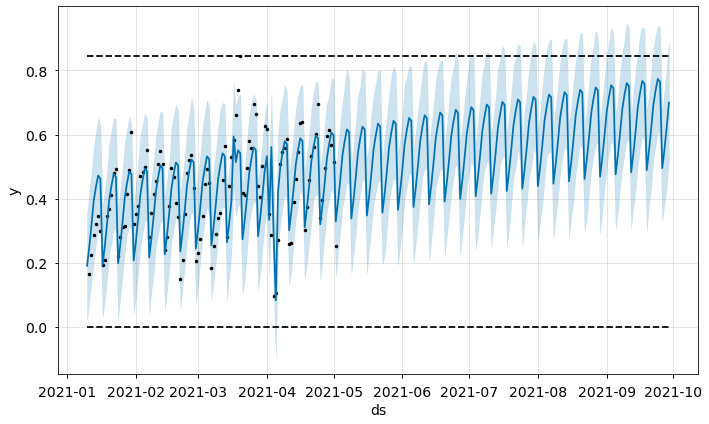

In [58]:
m.plot(forecast);

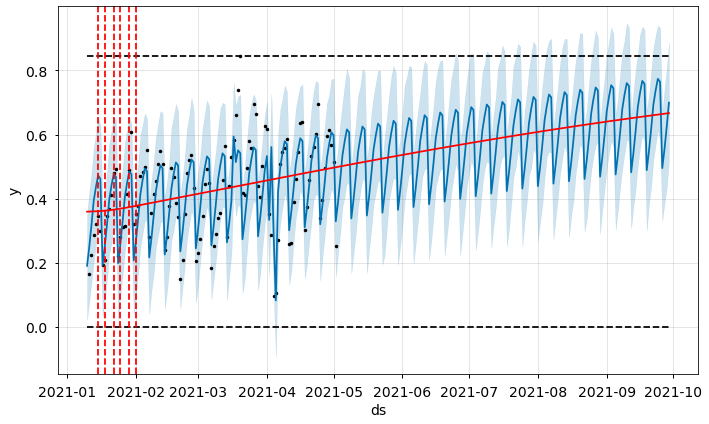

In [59]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

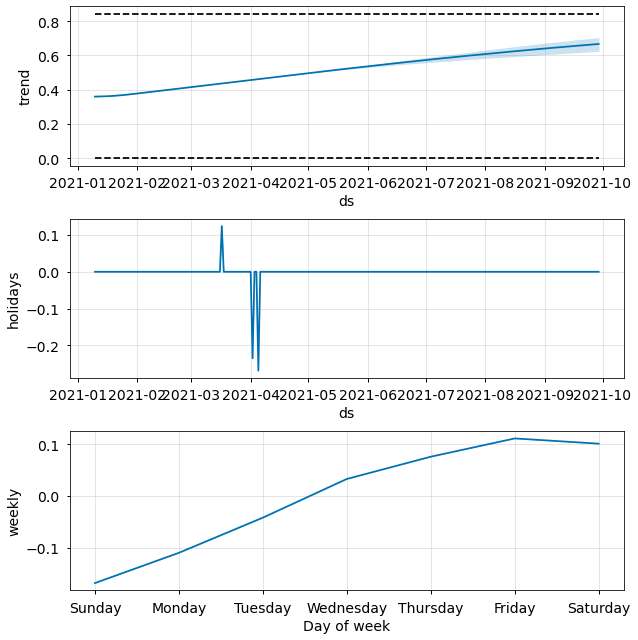

In [60]:
m.plot_components(forecast);

In [61]:
samples = m.predictive_samples(future)

In [62]:
samples["trend"]

array([[0.36004721, 0.36004721, 0.36004721, ..., 0.36004721, 0.36004721,
        0.36004721],
       [0.36028363, 0.36028363, 0.36028363, ..., 0.36028363, 0.36028363,
        0.36028363],
       [0.3605201 , 0.3605201 , 0.3605201 , ..., 0.3605201 , 0.3605201 ,
        0.3605201 ],
       ...,
       [0.72226305, 0.65531143, 0.70011918, ..., 0.67615234, 0.66508914,
        0.63245537],
       [0.72337665, 0.6560597 , 0.70132699, ..., 0.67700217, 0.6660835 ,
        0.63306878],
       [0.72448178, 0.65680586, 0.70252341, ..., 0.67784877, 0.66707194,
        0.63367237]])

(array([  6.,  31.,  78., 177., 265., 256., 130.,  44.,  10.,   3.]),
 array([0.10910433, 0.16983359, 0.23056285, 0.29129212, 0.35202138,
        0.41275064, 0.4734799 , 0.53420916, 0.59493842, 0.65566768,
        0.71639694]),
 <BarContainer object of 10 artists>)

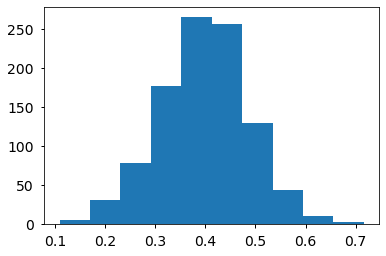

In [63]:
plt.hist(samples["yhat"][3])

<AxesSubplot:xlabel='ds'>

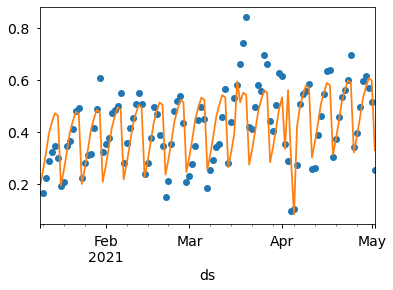

In [64]:
df["newTot"].plot(marker="o", linestyle="None")
m.predict(df_prophet).set_index("ds")["yhat"].plot()

In [65]:
forecast[["ds", "yhat_lower", "yhat", "yhat_upper"]]

,ds,yhat_lower,yhat,yhat_upper
0,2021-01-10,0.022663,0.191277,0.349695
1,2021-01-11,0.081581,0.250089,0.423587
2,2021-01-12,0.142374,0.318415,0.479941
3,2021-01-13,0.203575,0.393537,0.558718
4,2021-01-14,0.257872,0.436874,0.605177
...,...,...,...,...
258,2021-09-25,0.583042,0.764608,0.932538
259,2021-09-26,0.331586,0.495591,0.665393
260,2021-09-27,0.387191,0.555070,0.741496
261,2021-09-28,0.432667,0.624061,0.805326


In [66]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon = '14 days')

INFO:prophet:Making 8 forecasts with cutoffs between 2021-02-28 00:00:00 and 2021-04-18 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

In [67]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-03-01,0.291347,0.153890,0.424081,0.231450,2021-02-28
1,2021-03-02,0.369649,0.228959,0.501958,0.276310,2021-02-28
2,2021-03-03,0.437008,0.305029,0.574631,0.347406,2021-02-28
3,2021-03-04,0.473820,0.347150,0.612059,0.446450,2021-02-28
4,2021-03-05,0.495848,0.362030,0.632570,0.494235,2021-02-28
...,...,...,...,...,...,...
107,2021-04-28,0.512716,0.338906,0.683277,0.597025,2021-04-18
108,2021-04-29,0.559745,0.371349,0.738199,0.614135,2021-04-18
109,2021-04-30,0.600616,0.411164,0.795392,0.567374,2021-04-18
110,2021-05-01,0.588952,0.419048,0.754309,0.515479,2021-04-18


In [68]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,0.013340,0.115499,0.089946,0.326968,0.171129,0.249434,0.750000
1,3 days,0.009053,0.095148,0.083099,0.190055,0.160859,0.183935,0.840909
2,4 days,0.007100,0.084259,0.063761,0.125072,0.061306,0.126937,0.875000
3,5 days,0.015689,0.125257,0.083415,0.163706,0.061261,0.151489,0.784091
4,6 days,0.029904,0.172927,0.122944,0.254225,0.124591,0.220856,0.750000
5,7 days,0.021751,0.147482,0.112970,0.506573,0.244840,0.338835,0.750000
6,8 days,0.020394,0.142808,0.110886,0.586898,0.244840,0.365932,0.750000
7,9 days,0.017401,0.131912,0.109239,0.365150,0.268206,0.289126,0.750000
8,10 days,0.013253,0.115121,0.101490,0.215621,0.206284,0.215728,0.750000
9,11 days,0.010615,0.103031,0.088094,0.166485,0.094852,0.170397,0.840909


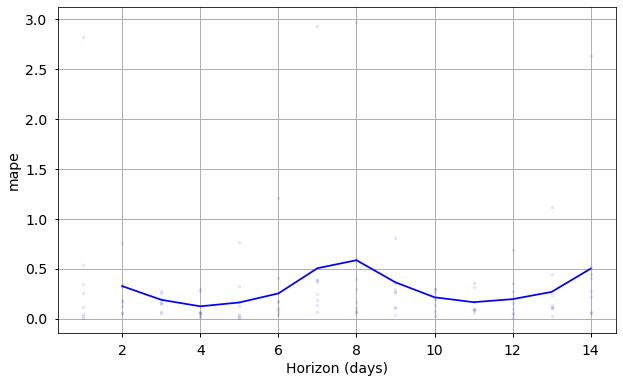

In [69]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


<AxesSubplot:xlabel='date'>

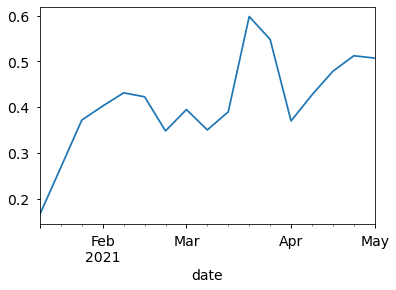

In [70]:
df.resample("W-MON").mean()["newTot"].plot()

In [86]:
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(df["newTot"].iloc[1:], test_size=21)

forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)


AutoARIMA(sp=12, suppress_warnings=True)

In [93]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_pred, y_test, labels=["y_train", "y_test", "y_pred"])


AttributeError: The `freq` attribute of the time index is required, but found: None. Please specify the `freq` argument when setting the time index.

In [92]:
fh

ForecastingHorizon(['2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15',
               '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19',
               '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
               '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29', '2021-04-30', '2021-05-01',
               '2021-05-02'],
              dtype='datetime64[ns]', name='date', freq='D', is_relative=False)